#                                               **COMBAT FINDER**
---

![](hit.gif)

* The project mainly revolves around detecting the violence particularly “fight” in the real time.The “combat finder” will do the job of detecting the violent attacks and alert the authorities in the right time which will be of immense help and assistance to the law and order establishment. The system can be of help not only in the field of crime detection but also in public school and other areas.

* A small working prototype of the combat finder which classifies the image into one of the labels below:                                  
          

| Class_labels | Label_ID |
| ------------ | -------- |
| Hit | 0 |
| Kick | 1 |
| Punch | 2 |
| Push | 3 |
| Ridehorse | 4 |
| Shootgun | 5 |
| Wave | 6 |
| Stand | 7 |


* When the datas from the dataset are passed into the network it produces one of the above 8 label id and trains the network to predicts the above 8 actions . The actions like hit ,kick,punch,shootgun comes under violence activity and are considered as "fight" and all other classes come under " non fight " category.

### Some pre-requisites

In [1]:
import os
import numpy as np
import torch
from PIL import Image
from torch.utils.data.dataset import Dataset
#from scipy.misc import imread
from torch import Tensor
import cv2
from matplotlib.pyplot import *
import torch.nn as nn
import torch
import torch.nn.functional as F

from model import SqueezeNet, Fire
from torch.utils.data import DataLoader
#from dataloader import fight
import matplotlib.pyplot as plt


## Let's load the data from the dataset first

* Pytorch has the data loading utility  called Dataloader which iterates over datasets.
* We go with the map-style dataset
* A map-style dataset is one that implements the __getitem__() and __len__() protocols, and represents a map from (possibly non-integral) indices/keys to data samples.

For example, such a dataset, when accessed with dataset[idx], could read the idx-th image and its corresponding label from a folder on the disk.

* We define the dataset class as "fight" and initialise it such that it reads the images and corresponding labels and put it together in the data and get_item is used to retrieve the images externally which we will see below

* For more information on pytorch refer https://pytorch.org/docs/stable/data.html

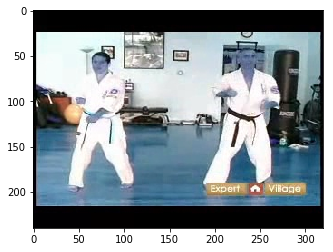

In [2]:
Image=(np.array(cv2.imread('/home/malar/prject_vision/dataset/train/2/punch986.jpg')))
plt.imshow(Image)

In [3]:
class fight(Dataset):
    def __init__(self, root):
        Image, Y = [], []
        folders = os.listdir(root)
        #value = 0
        for folder in folders:
            folder_path = os.path.join(root, folder)
            print(folder_path)
            for ims in os.listdir(folder_path):
                img_path = os.path.join(folder_path, ims)
                Image.append(np.array(cv2.imread(img_path)))
                Y.append(folder)
                #plt.imshow(Image)
            #value = value + 1
        data = [(x, y) for x, y in zip(Image, Y)]
        self.data = data

        # The number of items in the dataset
    def __len__(self):
        return len(self.data)

        # The Dataloader is a generator that repeatedly calls the getitem method.
        # getitem is supposed to return (X, Y) for the specified index.
   
    def __getitem__(self, index):
        img = self.data[index][0]
        dim = (224, 224)
        #  perform the actual resizing of the image and show it
        resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
        #img_resized = np.resize(img,(224,224,3))
        img = resized/255.0
        # Input for Conv2D should be Channels x Height x Width
        img_tensor = Tensor(img).view(3, 224, 224).float()
        label = self.data[index][1]
       # label_tensor = torch.FloatTensor(label)
        return (img_tensor, label)


 #### Lets call the dataloader and load our fight dataset

In [4]:
root = '/home/malar/prject_vision/'

# Instantiating the fight dataset class we created
train_dataset = fight(os.path.join(root, 'dataset/train'))
print("Loaded data")
print(train_dataset)
# Creating a dataloader
train_loader = DataLoader(dataset=train_dataset, batch_size=256 ,pin_memory=True )
print(len(train_dataset))

/home/malar/prject_vision/dataset/train/2
/home/malar/prject_vision/dataset/train/7
/home/malar/prject_vision/dataset/train/6
/home/malar/prject_vision/dataset/train/3
/home/malar/prject_vision/dataset/train/1
/home/malar/prject_vision/dataset/train/0
/home/malar/prject_vision/dataset/train/5
/home/malar/prject_vision/dataset/train/4
Loaded data
68048


### Let's see how the data's are loaded 

In [5]:
x,y = next(iter(train_loader))
x.shape,len(y)


(torch.Size([256, 3, 224, 224]), 256)

## Time to instantiate the model

* The squeezenet model came in 2016 after Alexnet with much lesser parameter to fit in one GPU while maintaining the same level of accuracy. Squeezenet V1.1 is recent version of squeezenet with lesser parameters compared to base line version
* To get a clear understanding we will take the layer from the torch vision library : https://github.com/pytorch/vision/blob/master/torchvision/models/squeezenet.py and import it as a class model for our project

![](squeezenet.png)

In [6]:
class Fire(nn.Module):

    def __init__(self, inplanes, squeeze_planes,
                 expand1x1_planes, expand3x3_planes):
        super(Fire, self).__init__()
        self.inplanes = inplanes
        self.squeeze = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
        self.squeeze_activation = nn.ReLU(inplace=True)
        self.expand1x1 = nn.Conv2d(squeeze_planes, expand1x1_planes,
                                   kernel_size=1)
        self.expand1x1_activation = nn.ReLU(inplace=True)
        self.expand3x3 = nn.Conv2d(squeeze_planes, expand3x3_planes,
                                   kernel_size=3, padding=1)
        self.expand3x3_activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.squeeze_activation(self.squeeze(x))
        return torch.cat([
            self.expand1x1_activation(self.expand1x1(x)),
            self.expand3x3_activation(self.expand3x3(x))
        ], 1)




In [7]:
class SqueezeNet(nn.Module):

    def __init__(self, num_classes=8):
        super(SqueezeNet, self).__init__()
        self.num_classes = num_classes
        self.features = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=3, stride=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(64, 16, 64, 64),
                Fire(128, 16, 64, 64),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(128, 32, 128, 128),
                Fire(256, 32, 128, 128),
                nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),
                Fire(256, 48, 192, 192),
                Fire(384, 48, 192, 192),
                Fire(384, 64, 256, 256),
                Fire(512, 64, 256, 256),
            )
       
        # Final convolution is initialized differently from the rest
        final_conv = nn.Conv2d(512, self.num_classes, kernel_size=1)
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            final_conv,
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return torch.flatten(x, 1)

* The building brick of SqueezeNet is called fire module, which contains two layers: a squeeze layer and an expand layer.
* Squeezing and expand layer are used to get high level abstract and at the samde time reducing the size of the feature map

### Lets call the model and define the loss/optimiser for  training

In [8]:
net = SqueezeNet(num_classes=8).cuda()
#print(net.is_cuda)
criterion = torch.nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(net.parameters(),lr = 1e-3)

![](fun_train.png)

In [10]:
EPOCHS =50

def train(epoch):
    epoch_loss = 0
    n_batches = len(train_dataset) // 256
    #print("n_batch {}".format(n_batches)) 
    loss_history = []
    for step, data in enumerate(train_loader, 0):
        train_x, train_y = data
        train_x = train_x.cuda()
        y_hat = net.forward(train_x)
        train_y = torch.Tensor(np.array(train_y,dtype='int32'))
        train_y = train_y.cuda()
        # CrossEntropyLoss requires arg2 to be torch.LongTensor
        loss = criterion(y_hat, train_y.long())
        epoch_loss += loss.item()
        optimizer.zero_grad()
        #print("Epoch {}, loss {} step{}".format(epoch, epoch_loss,step))
        # Backpropagation
        loss.backward()
        optimizer.step()
        # There are len(dataset)/BATCH_SIZE batches.
        # We print the epoch loss when we reach the last batch.
        if step % n_batches == 0 and step != 0:
            epoch_loss = epoch_loss / n_batches
            loss_history.append(epoch_loss)
            print("Epoch {}, loss {}".format(epoch, epoch_loss))
            epoch_loss = 0

In [11]:
for epoch in range(1, EPOCHS + 1):
    net.train()
    train(epoch)

Epoch 1, loss 27.725739686851792
Epoch 2, loss 4.3069962217419775
Epoch 3, loss 2.367988611167332
Epoch 4, loss 2.067768984020881
Epoch 5, loss 2.0925983136554933
Epoch 6, loss 2.067314342282853
Epoch 7, loss 2.0641189399755224
Epoch 8, loss 2.061369428994521
Epoch 9, loss 2.0594891269251985
Epoch 10, loss 2.058191539656441
Epoch 11, loss 2.0574300383621793
Epoch 12, loss 2.0569906432673615
Epoch 13, loss 2.056593290364967
Epoch 14, loss 2.056808608882832
Epoch 15, loss 2.0563222583734766
Epoch 16, loss 2.055812204109048
Epoch 17, loss 2.0554892692925795
Epoch 18, loss 2.0552173353591057
Epoch 19, loss 2.05457008784672
Epoch 20, loss 2.053652635160482
Epoch 21, loss 2.053589735391005
Epoch 22, loss 2.053460706854766
Epoch 23, loss 2.053353830553451
Epoch 24, loss 2.0533278262840127
Epoch 25, loss 2.0531652720469347
Epoch 26, loss 2.053031744597093
Epoch 27, loss 2.0530335376847466
Epoch 28, loss 2.0528863349050845
Epoch 29, loss 2.0528372368722594
Epoch 30, loss 2.0527942180633545
Epoc


## Now its time to test  the dataset


### Lets work with the simple accuracy calculation

In [12]:
root = '/home/malar/prject_vision/'
test_dataset = fight(os.path.join(root, 'dataset/test'))
test_loader = DataLoader(dataset=test_dataset, batch_size=1)
print(len(test_dataset))



/home/malar/prject_vision/dataset/test/2
/home/malar/prject_vision/dataset/test/7
/home/malar/prject_vision/dataset/test/6
/home/malar/prject_vision/dataset/test/3
/home/malar/prject_vision/dataset/test/1
/home/malar/prject_vision/dataset/test/0
/home/malar/prject_vision/dataset/test/5
/home/malar/prject_vision/dataset/test/4
7807


In [26]:
def test():
    correct = 0
    
    for step, data in enumerate(test_loader, 0):
        test_x,test_y = data
        test_x = test_x.cuda()
        pred = net.forward(test_x) 
        #print(len(test_x),len(test_y))
        pred = pred.cpu()
        #y_hat = np.argmax(pred.data)
        y_hat =pred.argmax()
        y_hat = y_hat.item()
        y =int(test_y[0])
        #print(y_hat)
        #print(y)
        if y_hat == y:
            correct+= 1
            # print("correct")
    print("Number of correct_predictions = {}".format(correct))
    print("Accuracy={}".format(correct*100 / len(test_dataset)))

In [27]:
test()

Number of correct_predictions = 1351
Accuracy=45.03333333333333


## **Future work**

* Improvise the model by tuning the hyper parameters and improve the accuracy rate (currently reading Bag of tricks paper https://arxiv.org/pdf/1812.01187.pdf to improvise)

* Use the inbuilt confusion matrix and better accuracy function to display the test data well.

* Code a module that categorize  the labels like hit,punch,shootgun,kick as "fight" and all other labels as "non fight"

* Extend the image classification to video on the same dataset HMDB51.

![](future.jpeg)